In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
import keras_tuner as kt
# from kerastuner.tuners import RandomSearch
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import pickle
import os

In [48]:
train_labels = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

train_img_dir = "histopathologic-cancer-detection/train"

test_img_dir = "histopathologic-cancer-detection/test"

In [49]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [50]:
(train_labels.label.value_counts() / len(train_labels)).to_frame()

,count
label,
0,0.594969
1,0.405031


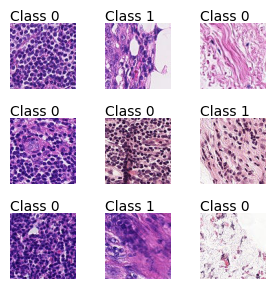

In [51]:
sample = train_labels.sample(n=9).reset_index()

plt.figure(figsize=(3,3))

for i, row in sample.iterrows():
    
    img = mpimg.imread(f'{train_img_dir}/{row.id}.tif')
    label = row.label

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')

    plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
train_df, valid_df = train_test_split(train_labels, test_size = 0.2, random_state=10, stratify=train_labels.label)

# print(train_df.shape)
# print(valid_df.size)

In [53]:
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1/255)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_img_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [55]:
TR_STEPS = len(train_generator)
VA_STEPS = len(validation_generator)

In [56]:
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3,3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(hp.Int('Conv3_units', min_value=32, max_value=128, step=32), (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=64, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [57]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='HCD_tuner_dir',
    project_name='HCD_SB_6'
)

tuner.search(train_generator, epochs=5, validation_data=validation_generator, validation_steps=VA_STEPS)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [06h 02m 17s]
val_accuracy: 0.8073627948760986

Best val_accuracy So Far: 0.8073627948760986
Total elapsed time: 19h 07m 58s


In [58]:
final_model = tuner.hypermodel.build(best_hps)

In [59]:
h1 = final_model.fit(
    train_generator,
    steps_per_epoch=TR_STEPS,
    epochs=3,
    validation_data = validation_generator,
    validation_steps = VA_STEPS,
    verbose=1
)

Epoch 1/3
2751/2751 [==============================] - 1377s 500ms/step - loss: 0.4568 - accuracy: 0.7970 - auc_1: 0.8612 - val_loss: 0.4162 - val_accuracy: 0.8227 - val_auc_1: 0.9027
Epoch 2/3
2751/2751 [==============================] - 1343s 488ms/step - loss: 0.3813 - accuracy: 0.8375 - auc_1: 0.9061 - val_loss: 0.3907 - val_accuracy: 0.8260 - val_auc_1: 0.9200
Epoch 3/3
2751/2751 [==============================] - 1396s 507ms/step - loss: 0.3626 - accuracy: 0.8478 - auc_1: 0.9155 - val_loss: 0.5163 - val_accuracy: 0.7836 - val_auc_1: 0.9256


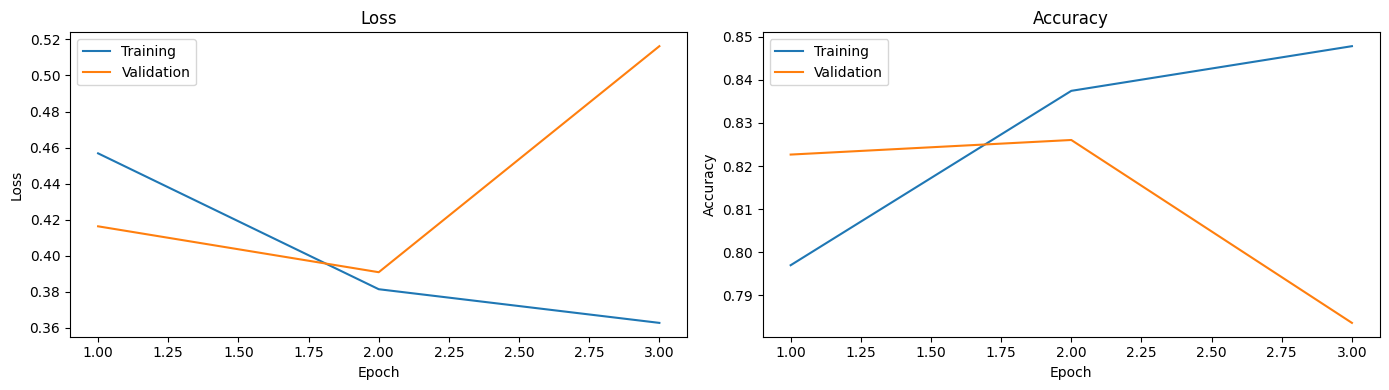

In [60]:
history = h1.history
epoch_range =range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
valid_df.head()

,id,label
185380,4198330bcadcb87818ff1f84ea2f86ca3c958c0a.tif,0
174148,70e80d021a09df59201bec28ff73b303abeb7fc6.tif,0
72606,816336cfb3623fa6693bf0a0012b897dddec6b7f.tif,1
201678,cd3a5115871c05648aa90899c6ada2c3dc4afdaa.tif,1
76835,7cb1fb6c0764e2b155921ed874329f1d9ce0919e.tif,0


In [75]:
test_data = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
test_data = test_data.astype(str)
test_data['id'] += '.tif'

In [76]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [77]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test_img_dir,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=64,
)

Found 57458 validated image filenames belonging to 1 classes.


In [78]:
predict_labels = final_model.predict(test_generator)

898/898 [==============================] - 90s 101ms/step


In [81]:
img_test = os.listdir(test_img_dir)

In [82]:
model_pred_df = pd.DataFrame(columns=['id', 'label'])
img_test = sorted(img_test)

model_pred_df['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df['label'] = np.round(predict_labels.flatten()).astype('int')
model_pred_df


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,1
4,000270442cc15af719583a8172c87cd2bd9c7746,1
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [83]:
model_pred_df.to_csv('cnn_detection.csv', index=False)